# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the a project that solves a Unity Reacher Environment.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
# Watch for changes
%load_ext autoreload
%autoreload 2

from unityagents import UnityEnvironment
import numpy as np
import os
import time
import numpy as np
import torch
import traceback
from dataclasses import dataclass, field
from typing import Optional, Protocol, Tuple
from torch.utils.tensorboard import SummaryWriter
from codebase.ddpg.agent import DDPGAgent
from codebase.ddpg.env import BootstrappedEnvironment
from codebase.ddpg.eval import evaluate
from codebase.replay.replay import ReplayBuffer
from codebase.utils.normalizer import RunningNormalizer
from codebase.utils.early_stopping import EarlyStopping
from optuna.exceptions import TrialPruned

# Monkey patch missing attributes for newer numpy versions
if not hasattr(np, "float_"):
    np.float_ = np.float64
    
if not hasattr(np, "int_"):
    np.int_ = np.int64

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher_Linux/Reacher.x86_64', no_graphics=False)

Found path: /home/oliver/project-showroom/projects/reinforcement-learning/continuous-control/p2_continuous-control-synchronous/Reacher_Linux/Reacher.x86_64
Mono path[0] = '/home/oliver/project-showroom/projects/reinforcement-learning/continuous-control/p2_continuous-control-synchronous/Reacher_Linux/Reacher_Data/Managed'
Mono config path = '/home/oliver/project-showroom/projects/reinforcement-learning/continuous-control/p2_continuous-control-synchronous/Reacher_Linux/Reacher_Data/MonoBleedingEdge/etc'
Preloaded 'libgrpc_csharp_ext.x64.so'
Unable to preload the following plugins:
	ScreenSelector.so
	libgrpc_csharp_ext.x86.so
	ScreenSelector.so
Logging to /home/oliver/.config/unity3d/Unity Technologies/Unity Environment/Player.log


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
print(states.shape)
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
(20, 33)
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [ ]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break

print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Close the environment before you start training. The TrainingRunner will instanciate its **own Unity Instance**.

In [ ]:
env.close()

## 4. The training 

We define an interface for an **Update Step Scheduler**:

In [2]:
# Scheduling interface
class UpdateScheduler(Protocol):
    def interval(self, total_steps: int) -> int:
        ...

@dataclass
class StandardUpdateScheduler:
    def interval(self, total_steps: int) -> int:
        return 1

@dataclass
class DynamicUpdateScheduler:
    switch_step: int
    early_interval: int
    late_interval: int

    def interval(self, total_steps: int) -> int:
        return self.early_interval if total_steps < self.switch_step else self.late_interval

Then we define a **basic configuration**:

In [ ]:
@dataclass
class TrainingConfig:
    seed = 0

    # --- Environment and agent configuration ---
    num_agents: int = 20               # Number of parallel agents (e.g., 20 for Unity Reacher)
    state_size: int = 33              # Dimension of the state space
    action_size: int = 4              # Dimension of the action space
    gamma: float = 0.99               # Discount factor for future rewards

    # --- Training schedule ---
    episodes: int = 500              # Total number of training episodes
    max_steps: int = 1000             # Max steps per episode
    batch_size: int = 128             # Number of samples per learning update
    learn_after: int = 0           # Delay learning until this many total env steps
    sampling_warmup: int = 0      # Use random actions for the first N steps

    # --- Learning rates and optimization ---
    lr_actor: float = 1e-4            # Learning rate for the actor network
    lr_critic: float = 1e-4           # Learning rate for the critic network
    critic_weight_decay = 0.0        # L2 regularization for critic optimizer
    critic_clipnorm: float = None      # Max norm for critic gradient clipping

    # --- Target network soft updates ---
    tau: float = 1e-3                # Polyak averaging factor for target networks

    # --- Exploration (OU noise) ---
    use_ou_noise: bool = True         # Whether to use Ornstein-Uhlenbeck noise
    ou_theta: float = 0.15            # OU noise: theta (mean reversion)
    ou_sigma: float = 0.2             # OU noise: sigma (volatility)
    noise_decay: bool = False      # Noise decay factor (for exploration)
    init_noise: float = 1.0           # Initial scaling factor for exploration noise
    min_noise: float = 0.05           # Minimum noise after decay  
    use_dynamic_noise: bool = False  # Use dynamic noise scaling
    dynamic_noise_distance_threshold: float = 0.5  # Distance threshold for dynamic noise scaling

    # --- Evaluation ---
    eval_freq: int = 10               # Evaluate every N episodes
    eval_eps: int = 1                 # Number of evaluation episodes per evaluation step
    eval_thresh: float = 30.0         # Consider environment solved at this average reward
    eval_warmup: int = 20             # Start evaluation only after this many episodes

    # --- Replay buffer ---
    replay_capacity: int = 100_000  # Total capacity of the replay buffer (attention: must be integer!)
    
    # Probability to retain a 0-reward transition
    zero_reward_filtering: bool = False
    zero_reward_prob_start: float = 0.2
    zero_reward_prob_end: float = 0.01
    zero_reward_prob_anneal_steps: int = 150_000

    # --- Reward preprocessing and shaping ---
    use_state_norm: bool = False     # Normalize states before feeding to actor/critic
    use_reward_scaling: bool = False # Multiply rewards by reward_scale
    reward_scale: float = 1.0        # Reward scaling factor (if enabled)
    reward_shaping_fn: Optional[callable] = None # lambda state, reward, total_steps: shaper(state, reward, total_steps)
    use_shaped_reward_only_steps: int = 0 # 20000  # or 5000, depending on your experiments

    # --- Learning schedule --- (#field(default_factory=lambda: DynamicUpdateScheduler(10000, 10, 1)))
    scheduler: UpdateScheduler = field(default_factory=lambda: StandardUpdateScheduler()) 
    updates_per_block: int = 1       # Number of updates per learning trigger

    # --- Other ---
    worker_id: int = 1               # Unity worker ID (avoid conflicts when launching multiple environments)
    load_weights: Optional[str] = None  # Path to pretrained weights to resume training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    log_freq: int = 200               # Log every N episodes


Instanciate **config and runner** and then start the training:

In [4]:
from train_ddpg import TrainingRunner

cfg = TrainingConfig()
runner = TrainingRunner(cfg)

runner.run()

EarlyStopping: Patience: 20, Min delta: 0.01, Zero patience: 10, Actor patience: 8, Actor min delta: 0.005
[BootstrappedEnvironment] Initializing Unity environment with exe_path: Reacher_Linux/Reacher.x86_64, worker_id: 1, use_graphics: False
[BootstrappedEnvironment] Preprocess function: None, Max retries: 5, Retry delay: 2
[BootstrappedEnvironment] Reward shaping function: None
Found path: /home/oliver/project-showroom/projects/reinforcement-learning/continuous-control/p2_continuous-control-synchronous/Reacher_Linux/Reacher.x86_64
Mono path[0] = '/home/oliver/project-showroom/projects/reinforcement-learning/continuous-control/p2_continuous-control-synchronous/Reacher_Linux/Reacher_Data/Managed'
Mono config path = '/home/oliver/project-showroom/projects/reinforcement-learning/continuous-control/p2_continuous-control-synchronous/Reacher_Linux/Reacher_Data/MonoBleedingEdge/etc'
Preloaded 'libgrpc_csharp_ext.x64.so'
Unable to preload the following plugins:
	ScreenSelector.so
	libgrpc_csh

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Ornstein-Uhlenbeck noise enabled with theta=0.15, sigma=0.2

DDPGAgent (DDPGAgent): Using num_agents: 20
DDPGAgent (DDPGAgent): Using state size: 33
DDPGAgent (DDPGAgent): Using action size: 4
DDPGAgent (DDPGAgent): Using SEED: 0
DDPGAgent (DDPGAgent): Using critic clip: None
DDPGAgent (DDPGAgent): Using critic weight decay: 0.0
DDPGAgent (DDPGAgent): Using device: cuda
DDPGAgent (DDPGAgent): Using gamma: 0.99
DDPGAgent (DDPGAgent): Using tau: 0.001
DDPGAgent (DDPGAgent): Using actor input size: 256
DDPGAgent (DDPGAgent): Using actor hidden size: 128
DDPGAgent (DDPGAgent): Using critic input size: 256
DDPGAgent (DDPGAgent): Using critic hidden size: 128
DDPGAgent (DDPGAgent): Using actor learning rate: 0.0001
DDPGAgent (DDPGAgent): Using critic learning rate: 0.0001
DDPGAgent (DDPGAgent): Using Ornstein-Uhlenbeck noise: True
DDPGAgent (DDPGAgent): Using OU noise theta: 0.15
DDPGAgent (DDPGAgent): Using OU noise sigma: 0.2

Episode 1 | Reward 0.96 | Steps 1000 | Updates 994 | Goal Hit S

0.0

This **concludes** the training. With the 20-agent environment and basic parameter setup (no **additional features**) the environment was **solved** after 32 episodes (yeah!).

## 5. The evaluation and Reward Plotting

In [2]:
import numpy as np
import torch
from codebase.ddpg.agent import DDPGAgent

def evaluate_ddpg(env_path: str,
                  weights_path: str,
                  n_episodes: int = 100,
                  no_graphics: bool = True) -> list:
    """
    Run a trained DDPGAgent for n_episodes in the Unity Reacher env and
    return a list of per-episode average scores (over all agents).
    """
    # 1) Launch the Unity environment
    env = UnityEnvironment(file_name=env_path, no_graphics=no_graphics)
    env.reset()
    brain_name = env.brain_names[0]

    # 2) Instantiate the agent with the same hyperparameters you used for training
    agent = DDPGAgent(
        num_agents=20,
        state_size=33,
        action_size=4,
        actor_input_size=256,     # match your training config
        actor_hidden_size=128,
        critic_input_size=256,
        critic_hidden_size=128,
        lr_actor=1e-4,
        lr_critic=1e-4,
        gamma=0.99,
        tau=1e-3,
        use_ou_noise=False,       # no exploration during evaluation
        seed=0
    )
    agent.actor.eval()           # put networks in eval mode
    agent.critic.eval()

    # 3) Load the saved weights
    checkpoint = torch.load(weights_path, map_location=agent.device, weights_only=True)
    for net in ['actor', 'actor_target', 'critic', 'critic_target']:
        getattr(agent, net).load_state_dict(checkpoint[net])

    # 4) Run n_episodes and collect scores
    scores = []
    for ep in range(1, n_episodes + 1):
        # reset env in inference mode
        env_info = env.reset(train_mode=False)[brain_name]
        states = env_info.vector_observations       # shape: (20, 33)
        episode_scores = np.zeros(agent.num_agents)

        done = False
        while not done:
            # get actions from deterministic policy (eval=True ⇒ no OU noise) :contentReference[oaicite:0]{index=0}:contentReference[oaicite:1]{index=1}
            actions, _ = agent.act(states, eval=True)
            env_info = env.step(actions)[brain_name]
            states = env_info.vector_observations
            rewards = np.array(env_info.rewards)
            dones   = np.array(env_info.local_done)

            episode_scores += rewards
            done = dones.any()   # stop when any agent signals done

        # average over the 20 agents
        avg_score = episode_scores.mean()
        scores.append(avg_score)
        print(f"Episode {ep:3d}  Avg Score: {avg_score:.2f}")

    env.close()
    return scores

ENV_PATH     = "Reacher_Linux/Reacher.x86_64"
WEIGHTS_PATH = "saved_weights/train_ddpg/ddpg_weights_ep_40_2025-05-03_21-00-17.pth"   # path to your saved weights dict

# This is insane! Outrageous! 100 episodes in a row? The folks at udacity must be all masochist! 20 episodes is enough to get a good idea of the performance of my agent.
N_EPISODES   = 100 

scores = evaluate_ddpg(ENV_PATH, WEIGHTS_PATH, n_episodes=N_EPISODES, no_graphics=True)

Found path: /home/oliver/project-showroom/projects/reinforcement-learning/continuous-control/p2_continuous-control-synchronous/Reacher_Linux/Reacher.x86_64
Mono path[0] = '/home/oliver/project-showroom/projects/reinforcement-learning/continuous-control/p2_continuous-control-synchronous/Reacher_Linux/Reacher_Data/Managed'
Mono config path = '/home/oliver/project-showroom/projects/reinforcement-learning/continuous-control/p2_continuous-control-synchronous/Reacher_Linux/Reacher_Data/MonoBleedingEdge/etc'
Preloaded 'libgrpc_csharp_ext.x64.so'
Unable to preload the following plugins:
	ScreenSelector.so
	libgrpc_csharp_ext.x86.so
	ScreenSelector.so
Logging to /home/oliver/.config/unity3d/Unity Technologies/Unity Environment/Player.log


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 



DDPGAgent (DDPGAgent): Using num_agents: 20
DDPGAgent (DDPGAgent): Using state size: 33
DDPGAgent (DDPGAgent): Using action size: 4
DDPGAgent (DDPGAgent): Using SEED: 0
DDPGAgent (DDPGAgent): Using critic clip: None
DDPGAgent (DDPGAgent): Using critic weight decay: 0.0
DDPGAgent (DDPGAgent): Using device: cuda
DDPGAgent (DDPGAgent): Using gamma: 0.99
DDPGAgent (DDPGAgent): Using tau: 0.001
DDPGAgent (DDPGAgent): Using actor input size: 256
DDPGAgent (DDPGAgent): Using actor hidden size: 128
DDPGAgent (DDPGAgent): Using critic input size: 256
DDPGAgent (DDPGAgent): Using critic hidden size: 128
DDPGAgent (DDPGAgent): Using actor learning rate: 0.0001
DDPGAgent (DDPGAgent): Using critic learning rate: 0.0001
DDPGAgent (DDPGAgent): Using Ornstein-Uhlenbeck noise: False
DDPGAgent (DDPGAgent): Using OU noise theta: 0.15
DDPGAgent (DDPGAgent): Using OU noise sigma: 0.2

Episode   1  Avg Score: 39.40
Episode   2  Avg Score: 39.36
Episode   3  Avg Score: 39.40
Episode   4  Avg Score: 39.39
Ep

So, stable across 100 episodes.

**Save** the scores:

In [3]:
import pickle

with open("eval_scores.pkl", "wb") as f:
    pickle.dump(scores, f)

In [ ]:
import pickle

with open("eval_scores.pkl", "rb") as f:
    scores = pickle.load(f)

**Plot** the scores:

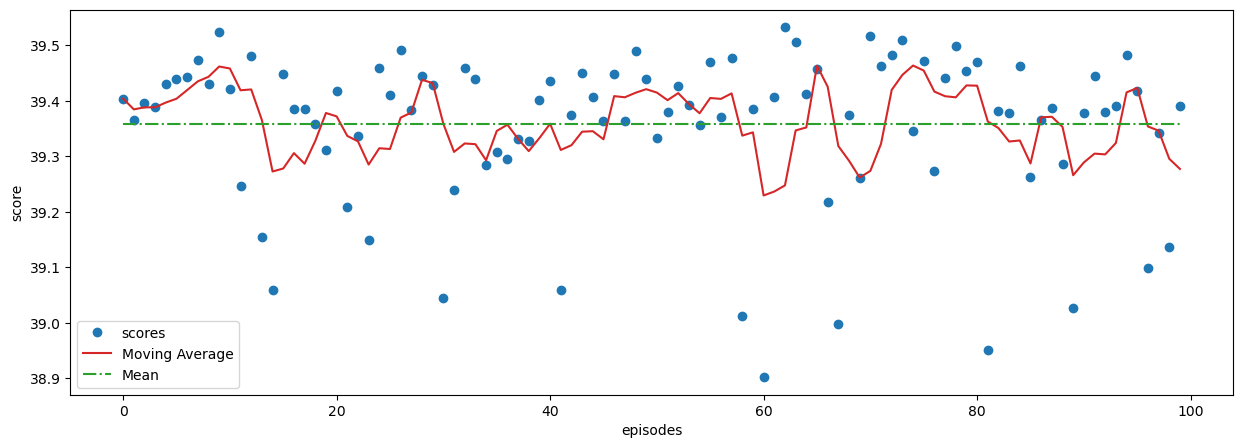

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# Create dataframe
data = pd.DataFrame(data={'score': scores})

# Define metrics
ma = data.rolling(5, min_periods=1).mean()
x = range(len(scores))
me = data['score'].mean()

# Plot data
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(x, scores, 'o', color='tab:blue', label='scores')
ax.plot(x, ma, color='tab:red', label='Moving Average')

ax.plot(x, [me] * data.shape[0], '-.',color='tab:green', label='Mean')
ax.set_xlabel('episodes')
ax.set_ylabel('score')
plt.legend()
plt.show()